In [1]:
import re
import numpy as np
import pandas as pd
import pickle
from eunjeon import Mecab
from gensim.models import Word2Vec as w2v
from sklearn.feature_extraction.text import CountVectorizer
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [21]:
#21대 국회 법안 데이터 전처리

df = pd.read_excel('21th_history.xlsx')

In [22]:
#가결/부결 코딩

for i in range(len(df)):
    if df.loc[i, '처리구분'] == 1 or df.loc[i, '처리구분'] == 2 or df.loc[i, '처리구분'] == 3 or df.loc[i, '처리구분'] == 4:
        df.loc[i, '처리구분'] = 1
    elif df.loc[i, '처리구분'] == 5 or df.loc[i, '처리구분'] == 9:
        df.loc[i, '처리구분'] = 1
    elif df.loc[i, '처리구분'] == 6 or df.loc[i, '처리구분'] == 7 or df.loc[i, '처리구분'] == 8:
        df.loc[i, '처리구분'] = 0
    elif df.loc[i, '처리구분'] == 10:
        df.loc[i, '처리구분'] = 0

In [23]:
#소관위 원-핫코딩
committee_set = list(set(df['소관위']))
committee = []
for com in committee_set:
    coms = com.split(", ")
    for c in coms:
        committee.append(c)
        
committee = list(set(committee))

for i in range(len(df)):
    if df['소관위'][i].__contains__('특별위원회'):
            df.loc[i, '특별위원회'] = 1
    for com in committee:
        if df['소관위'][i].__contains__(com):
            df.loc[i, com] = 1
        else:
            df.loc[i, com] = 0

In [24]:
for i in range(len(df)):
    if df.loc[i, '소속정당 구분'] == '더불어민주당' or df.loc[i, '소속정당 구분'] == '열린민주당':
        df.loc[i, 'party'] = 0
    elif df.loc[i, '소속정당 구분'] == '국민의힘' or df.loc[i, '소속정당 구분'] == '미래통합당' :
        df.loc[i, 'party'] = 1
    elif df.loc[i, '소속정당 구분'] == '국민의당' or df.loc[i, '소속정당 구분'] == '기본소득당' or df.loc[i, '소속정당 구분'] == '시대전환' or df.loc[i, '소속정당 구분'] == '정의당':
        df.loc[i, 'party'] = 2
    elif df.loc[i, '제안자'] == '위원장':
        df.loc[i, 'party'] = 4
    elif df.loc[i, '제안자'] == '정부':
        df.loc[i, 'party'] = 5
    else:
        df.loc[i, 'party'] = 3

In [25]:
for i in range(len(df)):
    if df.loc[i, '소속정당 구분'] == '더불어민주당' or df.loc[i, '소속정당 구분'] == '열린민주당' :
        df.loc[i, 'num_seats'] = 185
    elif df.loc[i, '소속정당 구분'] == '국민의힘' :
        df.loc[i, 'num_seats'] = 103
    elif df.loc[i, '소속정당 구분'] == '미래통합당' :
        df.loc[i, 'num_seats'] = 84
    elif df.loc[i, '소속정당 구분'] == '정의당' or df.loc[i, '소속정당 구분'] == '기본소득당' or df.loc[i, '소속정당 구분'] == '시대전환':
        df.loc[i, 'num_seats'] = 185
    elif df.loc[i, '소속정당 구분'] == '국민의당':
        df.loc[i, 'num_seats'] = 3
    elif df.loc[i, '소속정당 구분'] == '무소속':
        df.loc[i, 'num_seats'] = 9

In [26]:
#법안별 주요내용이 26개 카테고리 주제와 얼마나 유사한지 유사도 계산

model = w2v.load('word2vec.model') #모델 불러오기

tagger = Mecab()

summary_re=[]
for text in df['제안내용']:
    try:
        summary_re.append(re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z]', ' ', text))
    except:
        summary_re.append('NaN')
    
cnt_words = []
summary_re3 = []

for text in summary_re:
    pos_text = tagger.pos(text)
    word_list = []
    for word in pos_text:
        word_list.append(word[0])
    cnt_words.append(len(word_list)+1)
    summary_re3.append(' '.join(word_list))
    
df['제안내용_re']=summary_re3

In [27]:
words = list()
for word in model.wv.vocab:
    words.append(word)

#주제 카테고리 dic
category = {'국회': ['의회', '국회'],
            '정당/선거': ['정당', '선거'] ,
            '안보': ['군사', '안보', '북한'], 
            '사법': ['사법', '법원', '검찰', '소송'],
            '행정' : ['행정', '지자체', '자치', '경찰', '공무원'],
            '재정' : ['재정', '예산', '회계'], 
            '중소기업' : ['중소기업', '창업', '벤처', '스타트업'],
            '에너지' : ['에너지', '수소', '전기', '가스'], 
            '부동산' : ['주택', '부동산', '주거', '임대차'], 
            '금융' : ['금융', '투자', '자본', '보험업'], 
            '자동차' : ['자동차', '승합자동차', '이륜자동차', '승용차'],
            '건설/기계/조선' : ['기계', '건설업', '건설사', '건축', '조선업', '해운업', '발주'],
            '유통/무역' : ['유통', '물류', '무역', '쇼핑몰', '마트', '백화점'], 
            'IT' : ['IT', '통신', '게임', '데이터', '인공지능', '블록체인', '클라우드'], 
            '농축산' : ['농업', '축산', '수산'],
            '복지':['복지', '연금', '빈곤', '수당'],
            '의료/보건' : ['의료', '보건', '병원', '질병', '의약품'] , 
            '도시/교통':['도시', '교통', '운전', '도로'],
            '교육' : ['교육', '학교', '대학', '유치원', '입시'], 
            '환경' : ['친환경', '오염', '저탄소', '온실가스', '기후', '수자원'], 
            '노동' : ['노동', '임금', '노동조합', '퇴직', '채용', '근로'], 
            '치안/안전' : ['치안', '범죄', '안전', '사고', '소방', '형사'],  
            '가족' : ['가족', '아동', '청소년'],
            '여성' : ['여성', '출산', '육아', '성범죄', '성희롱'], 
            '예체능' : ['예술', '영화', '음악', '전시','공연', '문화재', '체육', '방송', '언론', '스포츠', '콘텐츠']
            }


for key in category.keys():
    keyword_similar = np.zeros(shape=(len(words), ))
    
    for keyword in category[key]:
        keyword_similar_2 = []
        for word in words:
            sm = model.wv.similarity(keyword, word)
            if sm >= 0.8:
                keyword_similar_2.append(sm)
            else:
                keyword_similar_2.append(0)

        keyword_similar_2 = np.asarray(keyword_similar_2)
        keyword_similar += keyword_similar_2
    
    keyword_similar = list(keyword_similar)
    keyword_similar_df = pd.DataFrame({'words': words, 'similar' : keyword_similar})
    keyword_similar_df = keyword_similar_df.sort_values(by=['words'], axis=0)
    keyword_similar_df = keyword_similar_df.set_index('words')
    keyword_similar_df = keyword_similar_df.T

    vectorizer = CountVectorizer(vocabulary = keyword_similar_df.columns, binary=False)
    X = vectorizer.fit_transform(summary_re3)
    words_df = pd.DataFrame(X.toarray(), columns = vectorizer.get_feature_names())
    words_df = words_df.T

    tdm = np.dot(keyword_similar_df, words_df)
    tdm = tdm.T
    tdm = np.ravel(tdm) #2차원 배열을 1차원으로 평평하게 만듬
    df[key] = list(tdm / cnt_words)

In [28]:
#공동발의데이터 전처리
spon = pd.read_csv('21th_sponsorship_0104.csv')
spon = spon.loc[ spon['의안번호'].isin(df['법안코드']) ].reset_index().drop(['index'],axis=1)
spon = spon[spon['구분']!='대표'].fillna(0)
spon = spon[spon['당선횟수']!=0]

In [29]:
#공동발의 의원들의 평균 선수
avg_elected = spon.pivot_table(index=['의안번호'], values=['당선횟수'], aggfunc=np.mean)
avg_elected = avg_elected.reset_index()

In [30]:
#정당다양성 변수: 공동발의 의원이 모두 같은 당 소속이면 0, 아니면 1

party_set = []

bill_no = list(set(spon['의안번호']))

for no in bill_no:
    bill = spon[spon['의안번호']==no]
    parties = set(bill['정당'])
    if len(parties) >= 2:
        party_set.append(1)
    else:
        party_set.append(0)
        
diversity = pd.DataFrame({'의안번호': bill_no, '정당다양성':party_set})

In [31]:
extra_var = pd.merge(avg_elected, diversity, how='left', on='의안번호')
extra_var = extra_var.rename(columns={"당선횟수": "공동발의평균선수"})
extra_var = extra_var.rename(columns={"의안번호": "법안코드"})

df = pd.merge(df, extra_var, how='left', on='법안코드')

In [32]:
#상임위 상정 여부 변수

for i in range(len(df)):
    if type(df.loc[i, '위원회 상정일']) == pd._libs.tslibs.timestamps.Timestamp:
        df.loc[i, '상임위 상정 여부'] = 1
    else:
        df.loc[i, '상임위 상정 여부'] = 0

# 반대당발언횟수 추가

In [6]:
import sqlite3
import pandas as pd
conn = sqlite3.connect("bills.db", isolation_level=None)
cursor = conn.cursor()

cursor.execute("select * from bills_2021")

rows = cursor.fetchall() 
cols = [column[0] for column in cursor.description]

df = pd.DataFrame.from_records(data=rows, columns=cols)

In [7]:
df

,billId,billName,billNo,passGubn,procStageCd,proposeDt,proposerKind,summary,generalResult,procDt,...,presentDt,COMMITTEE,PROC_RESULT,RST_PROPOSER,PUBL_PROPOSER,COMMITTEE_ID,polyNm,당선횟수,선출형태,반대당발언횟수
0,PRC_E2T0Y0L7N3T1A1F8Z0F7M3M8U0N9E9,건강가정기본법 일부개정법률안(강민정의원 등 11인),2102616,계류의안,소관위심사,2020-07-31,의원,제안이유 및 주요내용\r\n\r\n 사회적으로 큰 충격을 안긴 천안과 창녕의 아동...,None,None,...,2020-12-02,여성가족위원회,None,강민정,"김윤덕,박영순,서동용,심상정,양정숙,윤영덕,이수진,장혜영,전용기,황운하",9700342.0,열린민주당,1.0,비례대표,NaN
1,PRC_S2W0M0J7E3Y1N1O8M0E0I1B8R9B5S2,의료법 일부개정법률안(안규백의원 등 10인),2102615,계류의안,소관위심사,2020-07-31,의원,제안이유 및 주요내용\r\n\r\n 현행법에서는 수술실 내 영상정보처리기기(CCT...,None,None,...,2020-11-17,보건복지위원회,None,안규백,"김영배,김회재,문정복,박영순,양정숙,윤건영,윤재갑,이원택,정청래",9700341.0,더불어민주당,4.0,지역구,21.0
2,PRC_N2D0G0E7Z3J1I1Q7I5R8C3R5Z0S6V8,근로기준법 일부개정법률안(추경호의원 등 15인),2102614,계류의안,소관위심사,2020-07-31,의원,제안이유\r\n\r\n 현행법에 따르면 1주당 최대 근로시간을 52시간으로 단축하...,None,None,...,2020-09-22,환경노동위원회,None,추경호,"강대식,김승수,김용판,김정재,김희국,박덕흠,윤창현,이명수,임이자,정희용,조경태,조수...",9700038.0,국민의힘,2.0,지역구,NaN
3,PRC_N2Y0M0J7I3Q1G1Z7Z5C6Q1J9R8C3Q5,언론중재 및 피해구제 등에 관한 법률 일부개정법률안(신현영의원 등 10인),2102613,계류의안,소관위심사,2020-07-31,의원,제안이유\r\n\r\n 현행법에 따르면 언론 등의 보도 또는 매개(이하 “언론보도...,None,None,...,2020-09-18,문화체육관광위원회,None,신현영,"고영인,김병욱,김정호,박정,안민석,이성만,이탄희,이형석,임호선",9700513.0,더불어민주당,1.0,비례대표,3.0
4,PRC_E2K0U0D7C3Y1C1R7P5V4L1Q3H0T8U7,남녀고용평등과 일·가정 양립 지원에 관한 법률 일부개정법률안(전주혜의원 등 10인),2102612,계류의안,소관위심사,2020-07-31,의원,제안이유 및 주요내용\r\n\r\n 현행법은 사업주에게 근로자가 인공수정 또는 체...,None,None,...,2020-09-22,환경노동위원회,None,전주혜,"김미애,김영식,김정재,박성중,서정숙,윤창현,이용,최승재,한무경",9700038.0,국민의힘,1.0,비례대표,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7694,PRC_M2J1H0O1Q2E5G1D0W4D1T3Z8S4F1N0,국가경찰과 자치경찰의 조직 및 운영에 관한 법률 일부개정법률안(권은희의원 등 10인),2107611,계류의안,소관위접수,2021-01-25,의원,제안이유 및 주요내용\r\n\r\n 우리나라 경찰은 그 수가 10만이 넘으며 치안...,None,None,...,None,행정안전위원회,None,권은희,"권성동,김웅,김은혜,서정숙,유의동,윤한홍,이태규,최연숙,하태경",9700480.0,국민의당,3.0,비례대표,0.0
7695,PRC_P2H1Y0E1Q2Y5J1H0R2M7E5L7R5E3F3,동물보호법 일부개정법률안(김예지의원 등 10인),2107610,계류의안,접수,2021-01-25,의원,제안이유 및 주요내용\r\n\r\n 현행법은 반려동물 관련 영업자에 대하여 동물의...,None,None,...,None,농림축산식품해양수산위원회,None,김예지,"김선교,김희국,박진,윤재옥,이명수,이종성,전주혜,추경호,황보승희",9700408.0,국민의힘,1.0,비례대표,0.0
7696,PRC_Z2U1R0I1I1F1Z1X5T3I4V5J6L9B1A3,근로자참여 및 협력증진에 관한 법률 일부개정법률안(이수진의원등10인),2107609,계류의안,접수,2021-01-25,의원,제안이유 및 주요내용\r\n\r\n 최근 수급업체 소속 근로자들의 열악한 근로조건...,None,None,...,None,환경노동위원회,None,이수진,"강은미,김주영,민병덕,송옥주,심상정,양경숙,양정숙,윤영덕,윤준병",9700038.0,더불어민주당,1.0,비례대표,0.0
7697,PRC_R2B1O0G1J1A1D1B5D3K8J3A2S4Y9N1,장애인고용촉진 및 직업재활법 일부개정법률안(이수진의원 등 10인),2107608,계류의안,접수,2021-01-25,의원,제안이유 및 주요내용\r\n\r\n 현행법은 일정 규모 이상의 사업주로 하여금 특...,None,None,...,None,환경노동위원회,None,이수진,"강은미,심상정,양경숙,양정숙,윤영덕,윤준병,이규민,정찬민,최연숙",9700038.0,더불어민주당,1.0,비례대표,0.0


In [5]:
df.columns

Index(['billId', 'billName', 'billNo', 'passGubn', 'procStageCd', 'proposeDt',
       'proposerKind', 'summary', 'generalResult', 'procDt', 'index', '공동발의자수',
       '공동발의평균선수', 'diversity', 'presentDt', 'COMMITTEE', 'PROC_RESULT',
       'RST_PROPOSER', 'PUBL_PROPOSER', 'COMMITTEE_ID', 'polyNm', '당선횟수',
       '선출형태', '반대당발언횟수', 'a'],
      dtype='object')

In [71]:
df[df['billId']=='PRC_B2T0C0I9W0W3S1X1F0G4E3X2R1M1Y4']['presentDt']

109    None
Name: presentDt, dtype: object

In [7]:
idx = 'PRC_Q2T1M0X1D0M4W1T4M3O0R3Y4C7O3D2'
url = f"http://apis.data.go.kr/9710000/BillInfoService2/getBillCommissionExaminationInfo?bill_id={idx}&ServiceKey=" + MYKEY2
req = requests.get(url)
xpars = xmltodict.parse(req.text)
jsonDump = json.dumps(xpars)
jsonBody = json.loads(jsonDump)
dt = jsonBody['response']['body']['JurisdictionExamination']['item']
dt

{'committeeName': '문화체육관광위원회',
 'presentDt': None,
 'procDt': None,
 'procResultCd': None,
 'submitDt': '2021-01-18'}

In [10]:
conn = sqlite3.connect("bills.db", isolation_level=None)
cursor = conn.cursor()

cursor.execute("select * from bills_2021")
rows = cursor.fetchall()
cols = [column[0] for column in cursor.description]

df = pd.DataFrame.from_records(data=rows, columns=cols)

In [40]:
df.columns

Index(['billId', 'billName', 'billNo', 'passGubn', 'procStageCd', 'proposeDt',
       'proposerKind', 'summary', 'generalResult', 'procDt', 'index', '공동발의자수',
       '공동발의평균선수', 'diversity', 'presentDt', 'COMMITTEE', 'PROC_RESULT',
       'RST_PROPOSER', 'PUBL_PROPOSER', 'COMMITTEE_ID', 'polyNm', '당선횟수',
       '선출형태'],
      dtype='object')

In [49]:
mykey = "f9191bcb5fc3472890a5e84347ae5ebb"
url3 = f"https://open.assembly.go.kr/portal/openapi/nwvrqwxyaytdsfvhu?KEY={mykey}&Type=json&pSize=300"
req = requests.get(url3).json()
congressman = pd.DataFrame(req['nwvrqwxyaytdsfvhu'][1]['row'])

for i in range(len(congressman)):
    congressman.loc[i, '당선횟수'] = len(congressman.loc[i, 'UNITS'].split(', '))

In [69]:
congressman[congressman['HG_NM']=='양금희']

,HG_NM,HJ_NM,ENG_NM,BTH_GBN_NM,BTH_DATE,JOB_RES_NM,POLY_NM,ORIG_NM,ELECT_GBN_NM,CMIT_NM,...,SEX_GBN_NM,TEL_NO,E_MAIL,HOMEPAGE,STAFF,SECRETARY,SECRETARY2,MONA_CD,MEM_TITLE,당선횟수
145,양금희,梁琴喜,YANG KUMHEE,양,1961-11-15,위원,국민의힘,대구 북구갑,지역구,산업통상자원중소벤처기업위원회,...,여,02-784-7451~7453,ygoldh8999@naver.com,https://blog.naver.com/ygoldh8999,"박종욱, 이현진","김홍석, 이은정","유도영, 김균서, 양지, 권기환, 백승미",VG24001G,- 학 력 \r\n1968.03 ~ 1974.02 대구 남산초등학교\r\n1974....,1.0


In [55]:
congressman_re = congressman[['HJ_NM', 'POLY_NM', '당선횟수', 'ELECT_GBN_NM']]
congressman_re[congressman_re['HJ_NM']=='成一鍾']

,HJ_NM,POLY_NM,당선횟수,ELECT_GBN_NM
124,成一鍾,국민의힘,2.0,지역구


In [6]:
import requests
import xmltodict
import json
import pandas as pd


billId = 'PRC_Q2T1M0X1D0M4W1T4M3O0R3Y4C7O3D2'
MYKEY2 = "sh1BLNic10zE0pynUHLuP0%2FDxTd5Fi4m5%2B4CojHK%2B%2BXTxH9ykyO3yVPROWHp3zsR9%2BB38%2BkIGmWgHB%2BYfmUB6A%3D%3D"
url2 = f"http://apis.data.go.kr/9710000/BillInfoService2/getBillPetitionMemberList?gbn1=bill&gbn2=reception&bill_id={billId}&ServiceKey=" + MYKEY2

req = requests.get(url2)
xpars = xmltodict.parse(req.text)

jsonDump = json.dumps(xpars)
jsonBody = json.loads(jsonDump)

date = pd.DataFrame(jsonBody['response']['body']['items']['item'])

In [3]:
for i in range(len(date)):
    if date.loc[i, 'polyNm'] == '미래통합당':
        date.loc[i, 'polyNm'] = '국민의힘'

In [5]:
date.loc[0, 'polyNm']

'더불어민주당'

In [15]:
a = df[df['선출형태']!='비례대표']
b = a[a['선출형태']!='지역구']
c = b[b['proposerKind']=='의원']
set(c['RST_PROPOSER'])

{None, '박덕흠', '전봉민'}

In [23]:
committee = ['보건복지위원회',
       '행정안전위원회', '산업통상자원중소벤처기업위원회', '문화체육관광위원회', '국회운영위원회', '법제사법위원회',
       '국방위원회', '국토교통위원회', '기획재정위원회', '특별위원회', '여성가족위원회', '농림축산식품해양수산위원회',
       '외교통일위원회', '정보위원회', '과학기술정보방송통신위원회', '환경노동위원회', '교육위원회', '정무위원회']

for com in committee:
    if com not in df.columns:
        df[com] = 0
        
data = pd.get_dummies(df,columns=['입법형태','선출형태', 'party', '정당다양성', '상임위 상정 여부'])

In [24]:
data.columns

Index(['법안코드', '법안명', 'billNo', 'passGubn', 'procStageCd', '접수일자',
       'proposerKind', 'summary', 'generalResult', 'procDt', 'index', '공동발의자수',
       '공동발의평균선수', 'presentDt', 'COMMITTEE', 'PROC_RESULT', '제안자',
       'PUBL_PROPOSER', 'COMMITTEE_ID', 'polyNm', '당선횟수', '처리구분', '특별위원회',
       '환경노동위원회', '여성가족위원회', '법제사법위원회', '농림축산식품해양수산위원회', '기획재정위원회', '국방위원회',
       '과학기술정보방송통신위원회', '산업통상자원중소벤처기업위원회', '국토교통위원회', '행정안전위원회', '보건복지위원회',
       '문화체육관광위원회', '교육위원회', '외교통일위원회', '정무위원회', '국회운영위원회', 'num_seats',
       'summary_re', '국회', '정당/선거', '안보', '사법', '행정', '재정', '중소기업', '에너지',
       '부동산', '금융', '자동차', '건설/기계/조선', '유통/무역', 'IT', '농축산', '복지', '의료/보건',
       '도시/교통', '교육', '환경', '노동', '치안/안전', '가족', '여성', '예체능', '반대당발언횟수',
       '정보위원회', '입법형태_일부개정법률안', '입법형태_전부개정', '입법형태_제정', '선출형태_비례대표',
       '선출형태_지역구', 'party_0', 'party_1', 'party_2', 'party_3', 'party_4',
       'party_5', '정당다양성_0.0', '정당다양성_1.0', '상임위 상정 여부_0.0', '상임위 상정 여부_1.0'],
      dtype='object')

In [50]:
#소관위에서 대표발의자와 다른 정당 의원이 발언한 횟수 변수화하기
hearings = pd.read_excel('hearings_count.xlsx') #회의록 데이터
hearings = hearings.rename(columns={"법안번호": "법안코드"})
hearings = hearings.loc[ hearings['법안코드'].isin(df['법안코드']) ].reset_index().drop(['index'],axis=1)
hearings_df = pd.merge(hearings, df, how='left', on='법안코드')

In [24]:
df.columns

Index(['billId', 'billName', 'billNo', 'passGubn', 'procStageCd', 'proposeDt',
       'proposerKind', 'summary', 'generalResult', 'procDt', 'index', '공동발의자수',
       '공동발의평균선수', 'diversity', 'presentDt', 'COMMITTEE', 'PROC_RESULT',
       'RST_PROPOSER', 'PUBL_PROPOSER', 'COMMITTEE_ID', 'polyNm', '당선횟수',
       '선출형태'],
      dtype='object')

In [72]:
import pandas as pd
conn = sqlite3.connect("bills.db", isolation_level=None)
cursor = conn.cursor()

cursor.execute("select * from bills_2021")
rows = cursor.fetchall()
cols = [column[0] for column in cursor.description]

df = pd.DataFrame.from_records(data=rows, columns=cols)
df = df.rename(columns={'billId':'법안코드'})

hearings = pd.read_excel('hearings_0125.xlsx') #회의록 데이터
hearings = hearings.rename(columns={"pbl_id": "법안코드"})
hearings = hearings.loc[ hearings['법안코드'].isin(df['법안코드']) ].reset_index().drop(['index'],axis=1)
hearings_df = pd.merge(hearings, df, how='left', on='법안코드')

In [ ]:
#잠시보류
import numpy as np
count_full = hearings.pivot_table(index='법안코드', values='횟수', aggfunc=np.sum).reset_index()
count_full = count_full.rename(columns={'횟수':'전체횟수'})

In [73]:
from datetime import datetime

party_21th = pd.read_csv('party_21th.csv')
party_21th = party_21th[['emp_nm', 'poly_nm']]
party_21th = party_21th.rename(columns={'emp_nm':'화자'})
df_merged = pd.merge(hearings_df, party_21th, how='left', on='화자')
#df_merged = df_merged.rename(columns={'정당':'제안자 정당'}).reset_index()
df_merged = df_merged.rename(columns={'poly_nm':'화자 정당'})

In [34]:
df_merged.columns

Index(['대수', '법안코드', '법안명', '직책', '화자', 'count', 'billName', 'billNo',
       'passGubn', 'procStageCd', 'proposeDt', 'proposerKind', 'summary',
       'generalResult', 'procDt', 'index', '공동발의자수', '공동발의평균선수', 'diversity',
       'presentDt', 'COMMITTEE', 'PROC_RESULT', '제안자', 'PUBL_PROPOSER',
       'COMMITTEE_ID', 'polyNm', '당선횟수', '선출형태', '화자 정당', '제안자 정당'],
      dtype='object')

In [74]:
party_21th = party_21th.rename(columns={'화자':'제안자'})
df_merged = df_merged.rename(columns={'RST_PROPOSER':'제안자'})
df_merged = pd.merge(df_merged, party_21th, how='left', on='제안자')
df_merged = df_merged.rename(columns={'poly_nm':'제안자 정당'})

In [75]:
df_merged['상임위원장 정당'] = '더불어민주당'

for i in range(len(df_merged)):
    if df_merged.loc[i, '제안자'] == '위원장': #위원장이 발의한 경우 상임위원장 정당을 제안자 정당으로 본다
        df_merged.loc[i, '제안자 정당'] = df_merged.loc[i, '상임위원장 정당']
        
for i in range(len(df_merged)):
    if df_merged.loc[i, '제안자'] == '정부':   #정부가 발의한 경우 더불어민주당(20대 국회 하반기: 문재인 정부)을 제안자 정당으로 본다
        df_merged.loc[i, '제안자 정당'] = '더불어민주당'

In [38]:
df_merged

Index(['대수', '법안코드', '법안명', '직책', '화자', 'count', 'billName', 'billNo',
       'passGubn', 'procStageCd', 'proposeDt', 'proposerKind', 'summary',
       'generalResult', 'procDt', 'index', '공동발의자수', '공동발의평균선수', 'diversity',
       'presentDt', 'COMMITTEE', 'PROC_RESULT', '제안자', 'PUBL_PROPOSER',
       'COMMITTEE_ID', 'polyNm', '당선횟수', '선출형태', '화자 정당', '제안자 정당',
       '상임위원장 정당'],
      dtype='object')

In [76]:
bill_no = list(set(df_merged['법안코드']))

cnt_list = []

for no in bill_no:
    bill_df = df_merged[df_merged['법안코드']==no].reset_index()
    cnt = 0
    for i in range(len(bill_df)):
        if bill_df['제안자 정당'][0] != bill_df.loc[i, '화자 정당'] and type(bill_df.loc[i, '화자 정당']) == str:
            cnt+=bill_df.loc[i, 'count']
    cnt_list.append(cnt)

bill_cnt = pd.DataFrame({'반대당발언횟수': cnt_list, '법안코드':bill_no})

In [66]:
bill_cnt = pd.merge(bill_cnt, count_full, how='left', on='법안코드')

In [77]:
bill_cnt

,반대당발언횟수,법안코드
0,4,PRC_J2Q0S0C6A2Q2N1I4B1J2K2I2O2Z9J0
1,18,PRC_S2K0G0G9B0I2T0Z9L4C8R1N5B3A7U0
2,26,PRC_G2X0C0O9N0I1N1N4U5H6G3G0O3C0P0
3,0,PRC_H2N0C0Y9Z0B2W1S1C5R0I4I9I4L7S3
4,0,PRC_H2R0X0G6Y1I6Z1H8R5V8M4P6H3K9T3
...,...,...
2891,3,PRC_N2U0P0C8C0S7X1O4Y0V1D1Y2M6T6N5
2892,75,PRC_K2B0B0W6S2S5Q1X2V0H4N2Q1G7G2Z3
2893,4,PRC_V2U0N0U9Y0R9Z1O7Y3Y8A4U2V2L2V2
2894,3,ARC_D2X0Y0W6O1K7Y1K7X5I3F4E5Z0E1C7


In [42]:
cursor.execute('ALTER TABLE bills_2021 ADD COLUMN 반대당발언횟수 integer')

In [78]:
data = [tuple(x) for x in bill_cnt.to_numpy()]
data

[(4, 'PRC_J2Q0S0C6A2Q2N1I4B1J2K2I2O2Z9J0'),
 (18, 'PRC_S2K0G0G9B0I2T0Z9L4C8R1N5B3A7U0'),
 (26, 'PRC_G2X0C0O9N0I1N1N4U5H6G3G0O3C0P0'),
 (0, 'PRC_H2N0C0Y9Z0B2W1S1C5R0I4I9I4L7S3'),
 (0, 'PRC_H2R0X0G6Y1I6Z1H8R5V8M4P6H3K9T3'),
 (1, 'PRC_V2I0R0E7R1F0I1M8O0U2M0F9J3O5Q5'),
 (0, 'PRC_O2X0H0Q7C2F7T1K1P1C1L2M6M8M6E4'),
 (0, 'PRC_H2S0S0P7R0E7Q1R7Z2T4I5A3C8T1M1'),
 (1, 'PRC_C2H0W0H9L0F7V1H0B2O1S3C8A0R7M2'),
 (0, 'PRC_G2O0T0X8Z1S2U1G0N4P6B2V5Z0I7J4'),
 (0, 'PRC_S2I0O0L8A2J4S1T9K5O2P5K2A0U1G6'),
 (0, 'PRC_Y2O0U0C7M0N2U1F7W2F1Q2T6F4J9R6'),
 (0, 'PRC_T2S0W0O8Z0Y5K1L3G5E8D3D3U3Q3S4'),
 (5, 'PRC_W2I0F0P6X0H4L0B9E5G2Q5Q7B6Q5H9'),
 (0, 'PRC_I2D0C1V1K2G6S1J0A0B8W5H1T9N8H0'),
 (1, 'PRC_E2O0Q0L6D2O9O1R4B3R2T3A2X0L1T3'),
 (2, 'PRC_R2R0H0D6A2X4E1O7U5X8M4E6G8S5O1'),
 (1, 'PRC_L2J0Z0E8K3D1K1E1G5J7O1B1W1P7I3'),
 (86, 'PRC_S2O0Y0V6S0W4L0T9V4S8Q2T7R1O2R3'),
 (133, 'PRC_V2S0V0H7W2Z9M1H8P2I3M2V3D2C9G0'),
 (10, 'PRC_W2A0F0C8S0T3R1H1P2T4E4C3A6L3O2'),
 (2, 'PRC_D2S0L1D2B0X1Z0G0G0G3G2C0I2U7Y6'),
 (493, 'PRC_H2L0B0Q8W0M4O1

In [45]:
data = [tuple(x) for x in bill_cnt.to_numpy()]

sql = 'UPDATE bills_2021 SET 반대당발언횟수=? WHERE billId=?'
cursor.executemany(sql, data)
conn.commit()
conn.close()

In [86]:
import sqlite3
import pandas as pd
conn = sqlite3.connect("bills_preprocessed.db", isolation_level=None)
cursor = conn.cursor()

cursor.execute("select * from bills")

rows = cursor.fetchall() 
cols = [column[0] for column in cursor.description]

df = pd.DataFrame.from_records(data=rows, columns=cols)

In [87]:
df.columns

Index(['법안코드', '법안명', 'billNo', 'passGubn', 'procStageCd', '접수일자',
       'proposerKind', 'summary', 'generalResult', 'procDt', 'index', '공동발의자수',
       '공동발의평균선수', '정당다양성', 'presentDt', 'COMMITTEE', 'PROC_RESULT', '제안자',
       'PUBL_PROPOSER', 'COMMITTEE_ID', 'polyNm', '당선횟수', '선출형태', '처리구분',
       '특별위원회', '환경노동위원회', '여성가족위원회', '법제사법위원회', '농림축산식품해양수산위원회', '기획재정위원회',
       '국방위원회', '과학기술정보방송통신위원회', '산업통상자원중소벤처기업위원회', '국토교통위원회', '행정안전위원회',
       '보건복지위원회', '문화체육관광위원회', '교육위원회', '외교통일위원회', '정무위원회', '국회운영위원회', 'party',
       'num_seats', '입법형태', 'summary_re', '국회', '정당/선거', '안보', '사법', '행정',
       '재정', '중소기업', '에너지', '부동산', '금융', '자동차', '건설/기계/조선', '유통/무역', 'IT',
       '농축산', '복지', '의료/보건', '도시/교통', '교육', '환경', '노동', '치안/안전', '가족', '여성',
       '예체능', '상임위 상정 여부', '반대당발언횟수'],
      dtype='object')

In [60]:
a = df[df['generalResult']=='대안반영폐기']['passGubn']

In [67]:
set(df['passGubn'])

{None, '계류의안', '대안반영폐기', '수정가결', '원안가결', '처리의안', '철회'}

In [61]:
a = a.reset_index()

In [65]:
set(a['passGubn'])

{'대안반영폐기', '처리의안'}

In [66]:
a[a['passGubn']=='대안반영폐기']

,index,passGubn
836,4926,대안반영폐기
837,4970,대안반영폐기
838,5026,대안반영폐기
839,5151,대안반영폐기
840,5282,대안반영폐기
...,...,...
895,5924,대안반영폐기
896,5925,대안반영폐기
897,5926,대안반영폐기
898,5950,대안반영폐기


In [19]:
set(df['proposerKind'])

{'기타', '위원장', '의원', '의장', '정부'}

In [15]:
set(df['proposerKind'])

for i in range(len(df)):
    if df.loc[i,'proposerKind'] == '공포' or df.loc[i,'proposerKind'] == '대안반영폐기' or df.loc[i,'proposerKind'] == '본회의의결' or df.loc[i,'proposerKind'] == '소관위심사' or df.loc[i,'proposerKind'] == '소관위접수' or df.loc[i, 'proposerKind'] == '접수' or df.loc[i, 'proposerKind'] == '철회':
        result = df.loc[i, 'generalResult'] 
        kind = df.loc[i,'proposerKind']
        df.loc[i, 'generalResult'] = kind
        df.loc[i,'proposerKind'] = result

In [16]:
data = df[['generalResult', '법안코드']]
data = [tuple(x) for x in data.to_numpy()]

conn = sqlite3.connect("bills_preprocessed.db", isolation_level=None)
cursor = conn.cursor()
sql = 'UPDATE bills SET generalResult=? WHERE 법안코드=?'
cursor.executemany(sql, data)
conn.commit()
conn.close()

In [17]:
data = df[['proposerKind', '법안코드']]
data = [tuple(x) for x in data.to_numpy()]

conn = sqlite3.connect("bills_preprocessed.db", isolation_level=None)
cursor = conn.cursor()
sql = 'UPDATE bills SET proposerKind=? WHERE 법안코드=?'
cursor.executemany(sql, data)
conn.commit()
conn.close()

In [20]:
for i in range(len(df)):
    if df.loc[i, 'proposerKind'] == '위원장':
        df.loc[i, '제안자'] = '위원장'
        df.loc[i, 'party'] = 4
        
data = df[['제안자', '법안코드']]
data = [tuple(x) for x in data.to_numpy()]

conn = sqlite3.connect("bills_preprocessed.db", isolation_level=None)
cursor = conn.cursor()
sql = 'UPDATE bills SET 제안자=? WHERE 법안코드=?'
cursor.executemany(sql, data)
conn.commit()
conn.close()

In [21]:
data = df[['party', '법안코드']]
data = [tuple(x) for x in data.to_numpy()]

conn = sqlite3.connect("bills_preprocessed.db", isolation_level=None)
cursor = conn.cursor()
sql = 'UPDATE bills SET party=? WHERE 법안코드=?'
cursor.executemany(sql, data)
conn.commit()
conn.close()

In [22]:
test = df[df['proposerKind']=='위원장']

In [24]:
set(test['party'])

{4}

In [37]:
bill_df = pd.merge(df, bill_cnt, how='left', on='법안코드')

In [38]:
bill_df.to_csv('21th_bill_preprocessed.csv', encoding='utf-8-sig') #csv파일로 저장

In [1]:
import sqlite3
import pandas as pd
conn = sqlite3.connect("bills.db")
df = pd.read_sql("select * from bills_2021 where proposeDt >= '2021-01-01'", con = conn)

In [3]:
df.columns

Index(['level_0', 'billId', 'billName', 'billNo', 'passGubn', 'procStageCd',
       'proposeDt', 'proposerKind', 'summary', 'generalResult', 'procDt',
       'index', '공동발의자수', '공동발의평균선수', 'diversity', 'presentDt', 'COMMITTEE',
       'PROC_RESULT', 'RST_PROPOSER', 'PUBL_PROPOSER', 'COMMITTEE_ID',
       'polyNm', '당선횟수', '선출형태'],
      dtype='object')

In [4]:
df[['billId', 'billName', 'presentDt']]

,billId,billName,presentDt
0,PRC_G2K1E0H1K0X5L1V1X1O3E1K0X3W7Z0,전통시장 및 상점가 육성을 위한 특별법 일부개정법률안(이동주의원등18인),None
1,PRC_V2H1J0K1U0M4V1W8A2A4F1Y5A8D3E0,코로나19 감염병 피해 소상공인등 구제에 관한 특별법안(이동주의원등22인),None
2,PRC_L2O1Q0C1L0F4F1R5O2O6T1N1S9D7A6,소상공인기본법 일부개정법률안(이동주의원등17인),None
3,PRC_F2O1J0G1D1B1I1K7K5D0A3K3Q6R8G4,입양특례법 일부개정법률안(양경숙의원 등 10인),None
4,PRC_W2P1T0Y1F1L1W1J7C4Y9G4R0W3Q1A4,아동복지법 일부개정법률안(양경숙의원 등 10인),None
...,...,...,...
180,PRC_D2P1I0I1I0B4V1E1N5S4O3P2E0D2T8,북한이탈주민의 보호 및 정착지원에 관한 법률 일부개정법률안(지성호의원 등 10인),None
181,PRC_J2Z1V0Q1W0G4C1U1K2A8T2H9P8Y5R2,기부금품의 모집 및 사용에 관한 법률 일부개정법률안(한정애의원 등 14인),None
182,PRC_B2F1X0I1H0L4B1Q1R2W0E5T6K6A8R0,공직선거법 일부개정법률안(고용진의원 등 14인),None
183,PRC_B2O0G1W1G2U6V1M2J5E4Z3N4C4B2P0,주민등록법 일부개정법률안(이영의원등11인),None


In [6]:
set(df['presentDt'])

{'2020-12-03', '2021-01-08', None, 'None'}

In [11]:
for i in range(len(df)):
    if df.loc[i, 'presentDt'] != None or df.loc[i, 'presentDt'] != 'None':
        print(df.loc[i, 'billId'] + ":" + df.loc[i, 'billName']  type(df.loc[i, 'presentDt'])) 

TypeError: can only concatenate str (not "type") to str

In [50]:
committee_set.remove(None)

In [49]:
committee_set = list(set(df['COMMITTEE']))
committee_set

['기획재정위원회',
 '보건복지위원회',
 '환경노동위원회',
 '행정안전위원회',
 None,
 '국토교통위원회',
 '농림축산식품해양수산위원회',
 '교육위원회',
 '정무위원회',
 '국회운영위원회',
 '법제사법위원회',
 '국방위원회',
 '문화체육관광위원회',
 '외교통일위원회',
 '산업통상자원중소벤처기업위원회',
 '과학기술정보방송통신위원회',
 '여성가족위원회']

In [51]:
committee_set

['기획재정위원회',
 '보건복지위원회',
 '환경노동위원회',
 '행정안전위원회',
 '국토교통위원회',
 '농림축산식품해양수산위원회',
 '교육위원회',
 '정무위원회',
 '국회운영위원회',
 '법제사법위원회',
 '국방위원회',
 '문화체육관광위원회',
 '외교통일위원회',
 '산업통상자원중소벤처기업위원회',
 '과학기술정보방송통신위원회',
 '여성가족위원회']

In [45]:
set(df['proposeDt'])

{'2021-01-04',
 '2021-01-05',
 '2021-01-06',
 '2021-01-07',
 '2021-01-08',
 '2021-01-11',
 '2021-01-12'}

In [6]:
set(df['procStageCd'])

{'공포',
 '대안반영폐기',
 '본회의부의안건',
 '본회의불부의',
 '본회의의결',
 '소관위심사',
 '소관위심사보고',
 '소관위접수',
 '접수',
 '정부이송',
 '철회',
 '체계자구심사',
 '폐기'}

In [8]:
set(df['generalResult'])

{None, '대안반영폐기', '부결', '수정가결', '원안가결', '철회', '폐기'}

In [24]:
type(df.loc[4000, 'presentDt'])

str

In [46]:
df.columns

Index(['index', 'billId', 'billName', 'billNo', 'passGubn', 'procStageCd',
       'proposeDt', 'proposerKind', 'summary', 'generalResult', 'procDt',
       '공동발의자수', 'diversity', 'presentDt', 'COMMITTEE', 'PROC_RESULT',
       'RST_PROPOSER', 'PUBL_PROPOSER', 'COMMITTEE_ID', 'polyNm'],
      dtype='object')

In [2]:
import pandas as pd
import sqlite3
conn = sqlite3.connect("bills_preprocessed.db")
df = pd.read_sql("select * from bills", con = conn)

In [5]:
df.columns

Index(['level_0', '법안코드', '법안명', 'billNo', 'passGubn', 'procStageCd', '접수일자',
       'proposerKind', 'summary', 'generalResult', 'procDt', 'index', '공동발의자수',
       '공동발의평균선수', '정당다양성', 'presentDt', 'COMMITTEE', 'PROC_RESULT', '제안자',
       'PUBL_PROPOSER', 'COMMITTEE_ID', 'polyNm', '당선횟수', '선출형태', '처리구분',
       '특별위원회', '환경노동위원회', '여성가족위원회', '법제사법위원회', '농림축산식품해양수산위원회', '기획재정위원회',
       '국방위원회', '과학기술정보방송통신위원회', '산업통상자원중소벤처기업위원회', '국토교통위원회', '행정안전위원회',
       '보건복지위원회', '문화체육관광위원회', '교육위원회', '외교통일위원회', '정무위원회', '국회운영위원회', 'party',
       'num_seats', '입법형태', 'summary_re', '국회', '정당/선거', '안보', '사법', '행정',
       '재정', '중소기업', '에너지', '부동산', '금융', '자동차', '건설/기계/조선', '유통/무역', 'IT',
       '농축산', '복지', '의료/보건', '도시/교통', '교육', '환경', '노동', '치안/안전', '가족', '여성',
       '예체능', '상임위 상정 여부'],
      dtype='object')

In [4]:
set(df['proposerKind'])

{'기타', '위원장', '의원', '의장', '정부'}

In [ ]:
df[df['propose']]

In [ ]:
for i in range(len(df)):
    if df.loc[i, 'proposerKind'] == '위원장':
        df.loc[i, 'party'] = 4
    elif df.loc[i, 'proposerKind'] == '정부':
        df.loc[i, 'party'] = 5


In [ ]:
for i in range(len(df)):
    if df.loc[i, 'billName'].__contains__('전부개정법률안'):
        df.loc[i, '입법형태'] = '전부개정'
    elif df.loc[i, 'billName'].__contains__('일부개정법률안'):
        df.loc[i, '입법형태'] = '일부개정법률안'
    else:
        df.loc[i, '입법형태'] = '제정'

In [12]:
import requests
mykey = "f9191bcb5fc3472890a5e84347ae5ebb"
url3 = f"https://open.assembly.go.kr/portal/openapi/nwvrqwxyaytdsfvhu?KEY={mykey}&Type=json&pSize=300"
req = requests.get(url3).json()
congressman = pd.DataFrame(req['nwvrqwxyaytdsfvhu'][1]['row'])

for i in range(len(congressman)):
    congressman.loc[i, '당선횟수'] = len(congressman.loc[i, 'UNITS'].split(', '))

In [14]:
congressman['ELECT_GBN_NM']

0       지역구
1       지역구
2       지역구
3       지역구
4      비례대표
       ... 
295     지역구
296     지역구
297     지역구
298     지역구
299     지역구
Name: ELECT_GBN_NM, Length: 300, dtype: object

In [70]:
a = '?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?'

In [73]:
b = a.split(',')
len(b)

71

In [85]:
a = ['법안코드', '법안명', 'billNo', 'passGubn', 'procStageCd', '접수일자',
       'proposerKind', 'summary', 'generalResult', 'procDt', 'index', '공동발의자수',
       '공동발의평균선수', '정당다양성', 'presentDt', 'COMMITTEE', 'PROC_RESULT', '제안자',
       'PUBL_PROPOSER', 'COMMITTEE_ID', 'polyNm', '당선횟수', '선출형태', '처리구분',
       '특별위원회', '환경노동위원회', '여성가족위원회', '법제사법위원회', '농림축산식품해양수산위원회', '기획재정위원회',
       '국방위원회', '과학기술정보방송통신위원회', '산업통상자원중소벤처기업위원회', '국토교통위원회', '행정안전위원회',
       '보건복지위원회', '문화체육관광위원회', '교육위원회', '외교통일위원회', '정무위원회', '국회운영위원회', 'party',
       'num_seats', '입법형태', 'summary_re', '국회', '정당/선거', '안보', '사법', '행정',
       '재정', '중소기업', '에너지', '부동산', '금융', '자동차', '건설/기계/조선', '유통/무역', 'IT',
       '농축산', '복지', '의료/보건', '도시/교통', '교육', '환경', '노동', '치안/안전', '가족', '여성',
       '예체능', '상임위 상정 여부']

len(a)

71

# 법안별 예측 변수 기여도

In [2]:
import sqlite3
import pandas as pd
conn = sqlite3.connect("bills_preprocessed.db", isolation_level=None)
cursor = conn.cursor()

cursor.execute("select * from bills WHERE 접수일자>='2021-01-25'")

rows = cursor.fetchall() 
cols = [column[0] for column in cursor.description]

df = pd.DataFrame.from_records(data=rows, columns=cols)

In [4]:

committee = ['보건복지위원회',
       '행정안전위원회', '산업통상자원중소벤처기업위원회', '문화체육관광위원회', '국회운영위원회', '법제사법위원회',
       '국방위원회', '국토교통위원회', '기획재정위원회', '특별위원회', '여성가족위원회', '농림축산식품해양수산위원회',
       '외교통일위원회', '정보위원회', '과학기술정보방송통신위원회', '환경노동위원회', '교육위원회', '정무위원회']


for com in committee:
    if com not in df.columns:
        df[com] = 0


df = df[['법안코드', '법안명', '제안자', '접수일자', '당선횟수', '공동발의자수',
       '입법형태', '선출형태', '처리구분', 'num_seats', 'party', '보건복지위원회',
       '행정안전위원회', '산업통상자원중소벤처기업위원회', '문화체육관광위원회', '국회운영위원회', '법제사법위원회',
       '국방위원회', '국토교통위원회', '기획재정위원회', '특별위원회', '여성가족위원회', '농림축산식품해양수산위원회',
       '외교통일위원회', '정보위원회', '과학기술정보방송통신위원회', '환경노동위원회', '교육위원회', '정무위원회',
       '국회', '정당/선거', '안보', '사법', '행정', '재정', '중소기업', '에너지',
       '부동산', '금융', '자동차', '건설/기계/조선', '유통/무역', 'IT', '농축산', '복지', '의료/보건',
       '도시/교통', '교육', '환경', '노동', '치안/안전', '가족', '여성', '예체능','상임위 상정 여부', '반대당발언횟수', '공동발의평균선수',  '정당다양성']]

data = pd.get_dummies(df,columns=['입법형태','선출형태', 'party', '정당다양성', '상임위 상정 여부'])
data = data.rename(columns={'party_0':'party_0.0', 'party_1':'party_1.0', 'party_2':'party_2.0', 'party_3':'party_3.0', 'party_4':'party_4.0', 'party_5':'party_5.0'})

xgb_model_ncom = pickle.load(open('models/bill_prediction_ncom.pkl', "rb"))


col = ['당선횟수', '공동발의자수', 'num_seats', '보건복지위원회', '행정안전위원회', '산업통상자원중소벤처기업위원회', '문화체육관광위원회',
       '국회운영위원회', '법제사법위원회', '국방위원회', '국토교통위원회', '기획재정위원회', '특별위원회', '여성가족위원회', '농림축산식품해양수산위원회',
       '외교통일위원회', '정보위원회', '과학기술정보방송통신위원회', '환경노동위원회', '교육위원회', '정무위원회', '국회', '정당/선거', '안보', '사법', '행정',
       '재정', '중소기업', '에너지', '부동산', '금융', '자동차', '건설/기계/조선', '유통/무역', 'IT', '농축산', '복지', '의료/보건', '도시/교통', '교육',
       '환경', '노동', '치안/안전', '가족', '여성', '예체능', '반대당발언횟수', '공동발의평균선수', '입법형태_일부개정법률안', '입법형태_전부개정',
       '입법형태_제정', '선출형태_비례대표', '선출형태_지역구', 'party_0.0', 'party_1.0', 'party_2.0', 'party_3.0', 'party_4.0', 'party_5.0',
       '상임위 상정 여부_0.0', '상임위 상정 여부_1.0', '정당다양성_0.0', '정당다양성_1.0']

for column in col:
    if column not in data.columns:
        data[column] = 0

dt_ncom = data



col_re = ['당선횟수','공동발의자수', 'num_seats', '보건복지위원회', '행정안전위원회',
 '산업통상자원중소벤처기업위원회', '문화체육관광위원회', '국회운영위원회', '법제사법위원회',
 '국방위원회', '국토교통위원회', '기획재정위원회', '특별위원회', '여성가족위원회', '농림축산식품해양수산위원회', '외교통일위원회',
 '정보위원회', '과학기술정보방송통신위원회', '환경노동위원회', '교육위원회', '정무위원회', '국회', '정당/선거', '안보',
 '사법', '행정', '재정', '중소기업', '에너지', '부동산', '금융', '자동차', '건설/기계/조선', '유통/무역',
 'IT', '농축산', '복지', '의료/보건', '도시/교통', '교육', '환경', '노동', '치안/안전', '가족', '여성',
 '예체능', '공동발의평균선수', '입법형태_일부개정법률안', '입법형태_전부개정', '입법형태_제정', '선출형태_비례대표',
 '선출형태_지역구', 'party_0.0', 'party_1.0', 'party_2.0', 'party_3.0', 'party_4.0', 'party_5.0',
 '정당다양성_0.0', '정당다양성_1.0']

dt_ncom['prediction'] = xgb_model_ncom.predict(dt_ncom[col_re])

Glyph 8722 missing from current font.
Glyph 8722 missing from current font.


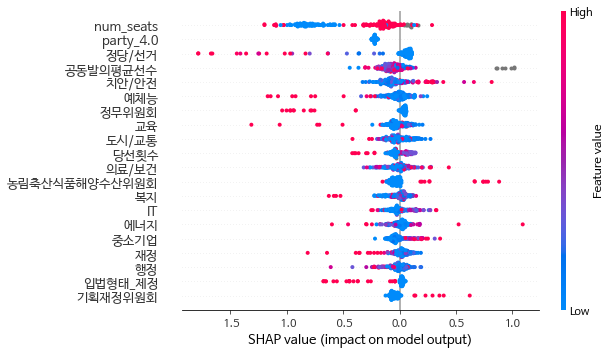

In [6]:
import shap

from matplotlib import font_manager, rc
import platform 
import matplotlib.pyplot as plt
%matplotlib inline


# 한글 폰트 사용
if platform.system() == 'Windows': 
    path = 'C:/Users/user/AppData/Local/Microsoft/Windows/Fonts/NanumBarunGothic.ttf'
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
elif platform.system() == 'Darwin':
    rc('font', family='AppleGothic')

    
explainer = shap.TreeExplainer(xgb_model_ncom)
shap_values = explainer.shap_values( dt_ncom[col_re] )
shap.summary_plot(shap_values, dt_ncom[col_re], plot_type = "dot", plot_size=0.2  )


In [30]:
i=33
shap.initjs()
shap.force_plot( explainer.expected_value , shap_values[i] , dt_ncom[col_re].iloc[i] )

In [28]:
dt_ncom.sort_values(by='prediction', ascending=False)

,법안코드,법안명,제안자,접수일자,당선횟수,공동발의자수,처리구분,num_seats,보건복지위원회,행정안전위원회,...,party_2.0,party_3.0,party_5.0,정당다양성_0.0,정당다양성_1.0,상임위 상정 여부_0.0,입법형태_전부개정,party_4.0,상임위 상정 여부_1.0,prediction
39,PRC_W2R0A1W2P2N8Q1O8T4G9O4Y0E9M5P9,지역문화진흥법 일부개정법률안(김승원의원등10인),김승원,2021-01-25,1.0,10.0,0.0,185.0,0,0,...,0,0,0,0,1,1,0,0,0,0.579725
20,PRC_Z2V1B0D1F2K6F1L7C0V1X5V3N6B1N8,농지법 일부개정법률안(김승남의원 등 10인),김승남,2021-01-26,2.0,10.0,0.0,185.0,0,0,...,0,0,0,1,0,1,0,0,0,0.544472
49,PRC_U2M1A0I1A2H9R1I4D3G7X2K3E7I7R5,2021년도 법률안 국회 제출계획(정부),정부,2021-01-29,NaN,NaN,0.0,NaN,0,0,...,0,0,1,0,0,1,0,0,0,0.536109
108,ARC_V2S1B0O1F2K8K1B6K1C0V2V9P4R8E4,하도급거래 공정화에 관한 법률 일부개정법률안(정부),정부,2021-01-28,NaN,NaN,0.0,NaN,0,0,...,0,0,1,0,0,1,0,0,0,0.505233
137,ARC_Y2F1O0E1E2U8R1S0Y5W7O4K4V1J8D1,법인세법 일부개정법률안(정부),정부,2021-01-28,NaN,NaN,0.0,NaN,0,0,...,0,0,1,0,0,1,0,0,0,0.494482
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,PRC_F2E1L0B1I2B8L1C8Y1W7D3F6T0V7Q4,대한민국재향경우회법 일부개정법률안(진선미의원 등 10인),진선미,2021-01-28,3.0,10.0,0.0,185.0,0,1,...,0,0,0,0,1,1,0,0,0,0.021101
122,PRC_X2E1O0L1T2G8I1B3R4N8H0K8G6O0R1,공직선거법 일부개정법률안(박완수의원 등 14인),박완수,2021-01-28,2.0,14.0,0.0,103.0,0,1,...,0,0,0,0,1,1,0,0,0,0.018224
33,PRC_B2J1E0H1N2C5G1S5F0B8O3C8L4M1P5,온라인 플랫폼 중개거래의 공정화에 관한 법률안(김병욱의원 등 12인),김병욱,2021-01-25,2.0,12.0,0.0,185.0,0,0,...,0,0,0,1,0,1,0,0,0,0.017363
160,PRC_U2F1L0N1R2C7N1C6V0E8L5L9T7I0W0,공직선거법 일부개정법률안(박형수의원 등 10인),박형수,2021-01-27,1.0,10.0,0.0,103.0,0,1,...,0,0,0,1,0,1,0,0,0,0.016464


In [12]:
dt_ncom.iloc[0]

법안코드             PRC_J2J1O0F1I1T4S1T8T0O9T3U6K9R2H0
법안명                     수산업협동조합법 일부개정법률안(윤준병의원등11인)
제안자                                             윤준병
접수일자                                     2021-01-26
당선횟수                                              1
                                ...                
상임위 상정 여부_0.0                                     1
입법형태_전부개정                                         0
party_4.0                                         0
상임위 상정 여부_1.0                                     0
prediction                                 0.123356
Name: 0, Length: 69, dtype: object

In [11]:
dt_ncom[col_re].iloc[0]

당선횟수                 1.000000
공동발의자수              11.000000
num_seats          185.000000
보건복지위원회              0.000000
행정안전위원회              0.000000
산업통상자원중소벤처기업위원회      0.000000
문화체육관광위원회            0.000000
국회운영위원회              0.000000
법제사법위원회              0.000000
국방위원회                0.000000
국토교통위원회              0.000000
기획재정위원회              0.000000
특별위원회                     NaN
여성가족위원회              0.000000
농림축산식품해양수산위원회        1.000000
외교통일위원회              0.000000
정보위원회                0.000000
과학기술정보방송통신위원회        0.000000
환경노동위원회              0.000000
교육위원회                0.000000
정무위원회                0.000000
국회                   0.052684
정당/선거                0.000000
안보                   0.000000
사법                   0.000000
행정                   0.000000
재정                   0.000000
중소기업                 0.000000
에너지                  0.000000
부동산                  0.000000
금융                   0.000000
자동차                  0.004398
건설/기계/조선             0.000000
유통/무역     